In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

from time import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer

import xgboost as xgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 15 seconds


In [33]:
from nn_helper import scale_train_data, scale_test_data
from loader import load_data, load_meta, make_submission

In [53]:
train, test = load_meta('train_meta.csv', 'test_meta.csv')
train.head()

,shot_id,shot_distance,last_moment,away,period_1,period_2,period_3,period_4,period_5,period_6,...,meta_knn020,meta_knn040,meta_knn080,meta_knn160,meta_knn320,meta_logreg,meta_rf,meta_sgd,meta_xgb,meta_net
0,2,15,False,True,1.0,0.0,0.0,0.0,0.0,0.0,...,0.30,0.325,0.350,0.31875,0.384375,0.278806,0.366212,0.304392,0.354917,0.246859
1,25,7,False,False,0.0,0.0,1.0,0.0,0.0,0.0,...,0.40,0.475,0.425,0.40625,0.431250,0.768993,0.678699,0.613597,0.781271,0.649674
2,53,7,False,False,1.0,0.0,0.0,0.0,0.0,0.0,...,0.30,0.400,0.350,0.41250,0.428125,0.264278,0.284780,0.319212,0.283519,0.288401
3,78,13,False,True,0.0,0.0,1.0,0.0,0.0,0.0,...,0.20,0.275,0.300,0.33750,0.356250,0.140113,0.286666,0.229547,0.225701,0.208433
4,102,0,False,True,0.0,0.0,1.0,0.0,0.0,0.0,...,0.85,0.850,0.725,0.66875,0.559375,0.984972,0.990961,0.804818,0.946610,0.920623


In [54]:
len(train.columns)

159

In [44]:
tfidf_trans = TfidfTransformer()
features = test.columns.tolist()
features.remove('shot_id')
X_tfidf = tfidf_trans.fit_transform(train[features].values.astype(np.float32)).toarray().astype(np.float32)
X_tfidf

array([[ 0.91416156,  0.        ,  0.08473919, ...,  0.01876492,
         0.02071074,  0.0190956 ],
       [ 0.92497784,  0.        ,  0.08038295, ...,  0.01991216,
         0.00982303,  0.01449115],
       [ 0.95849454,  0.        ,  0.06057864, ...,  0.01455158,
         0.01480577,  0.01274105],
       ..., 
       [ 0.93665266,  0.        ,  0.        , ...,  0.01512989,
         0.01136801,  0.01397529],
       [ 0.9675473 ,  0.        ,  0.        , ...,  0.00990449,
         0.00632314,  0.00777337],
       [ 0.720254  ,  0.        ,  0.        , ...,  0.02094186,
         0.02622484,  0.02794096]], dtype=float32)

In [6]:
clf = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8, nthread=-1,
                        learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=600,
                        objective='binary:logistic', seed=42, silent=True, subsample=0.8)

In [7]:
clf.fit(train.drop('shot_made_flag', axis=1), train.shot_made_flag)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=600, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.8)

In [8]:
predicted = clf.predict_proba(test)

In [10]:
predicted = predicted[:,1]

In [13]:
test['shot_made_flag'] = predicted

In [15]:
def make_prediction(predicted, ids, name):
    with open(name, 'w') as f:
        f.write('shot_id,shot_made_flag\n')
        for i, prob in zip(ids, predicted):
            f.write(str(i) + ',' + str(prob) + '\n')
    print('Wrote submission to file {}.'.format(name))

In [16]:
make_prediction(predicted, test.shot_id, 'ensemble_xgb.csv')

Wrote submission to file ensemble_xgb.csv.


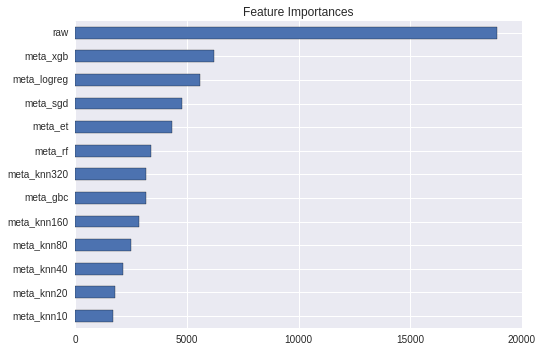

In [21]:
feature_importances = clf.booster().get_fscore()
raw = 0
keys = list(feature_importances.keys())
for key in keys:
    if not key.startswith('meta'):
        raw += feature_importances[key]
        feature_importances.pop(key, None)
feature_importances['raw'] = raw
pd.Series(feature_importances).sort_values(ascending=True).plot(kind='barh', title='Feature Importances')